<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#ANALYSIS" data-toc-modified-id="ANALYSIS-1">ANALYSIS</a></span></li><li><span><a href="#no-self-edge" data-toc-modified-id="no-self-edge-2">no self-edge</a></span></li><li><span><a href="#VIZ" data-toc-modified-id="VIZ-3">VIZ</a></span></li></ul></div>

In [1]:
import numpy as np, string, utils, preprocess
import nltk

In [20]:
np.power(2, 6)

64

In [37]:
quran = utils.load_text("books/quran-shakir.txt")
print(quran[:103])

max_dist = 10

quran_graph, words_map = preprocess.text_to_graph(quran, ignore_stopwords=True, words_map=True, max_dist=max_dist, max_weight=np.power(2, max_dist))
print("Sparsity: {:05.2f}%".format(100 * (1 - np.count_nonzero(quran_graph) / quran_graph.size)))

In the name of Allah, the Beneficent, the Merciful.
All praise is due to Allah, the Lord of the Worlds
Sparsity: 99.27%


In [38]:
#book_lems = preprocess.words_lems(quran, lower=True)
#words_map = preprocess.words_to_int(book_lems, ignore_punct=True)

In [52]:
quran_graph.shape

(3990, 3990)

In [75]:
word_map_used_inv[np.argmin(quran_graph.sum(axis=0))]

'supplier'

In [54]:
np.argmin(quran_graph.sum(axis=0))

3771

In [74]:
(quran_graph.sum(axis=0) == 0).sum()

1

In [56]:
word_map_used_inv = {i[1]:i[0] for i in words_map.items()}

In [57]:
def get_adjacent(word, n=10, word_map_used=words_map):
    index = word_map_used[word]
    for i in range(n):
        print(word_map_used_inv[np.argsort(quran_graph[index])[::-1][i]])

In [58]:
word_map_used_inv[0]

'unduly'

# ANALYSIS

In [92]:
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import sparse, stats, spatial
from sklearn import preprocessing, decomposition, model_selection

%matplotlib inline
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))

# no self-edge

In [93]:
for i in range(quran_graph.shape[0]):
    quran_graph[i, i] = 0

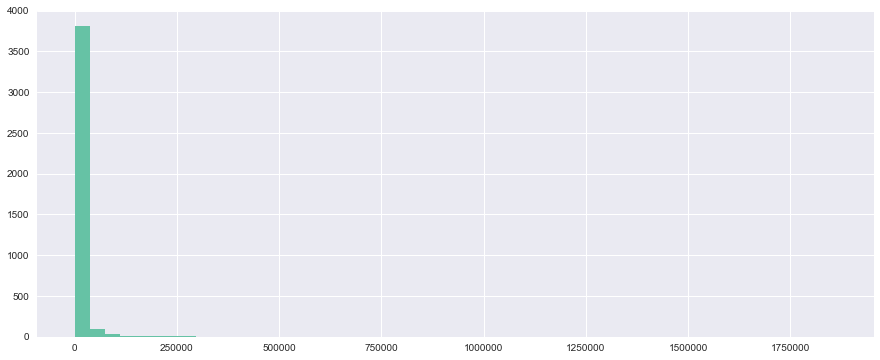

In [94]:
degrees = np.sum(quran_graph, axis=1)

plt.hist(degrees, bins=50);

In [95]:
D = np.diag(degrees)
W = quran_graph
L = D - W

In [96]:
inv_sqrt_D = np.diag(1 / np.diag(D**(0.5)))

In [97]:
normalized_laplacian = inv_sqrt_D @ L @ inv_sqrt_D

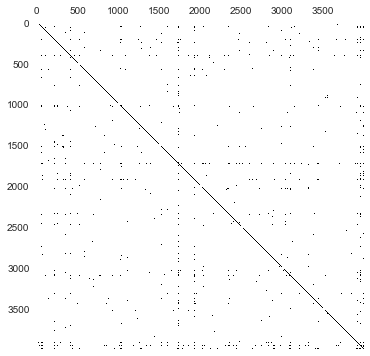

In [98]:
plt.spy(normalized_laplacian);

In [99]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(normalized_laplacian, k=10, which='SM') # which='SA' gives us similar results

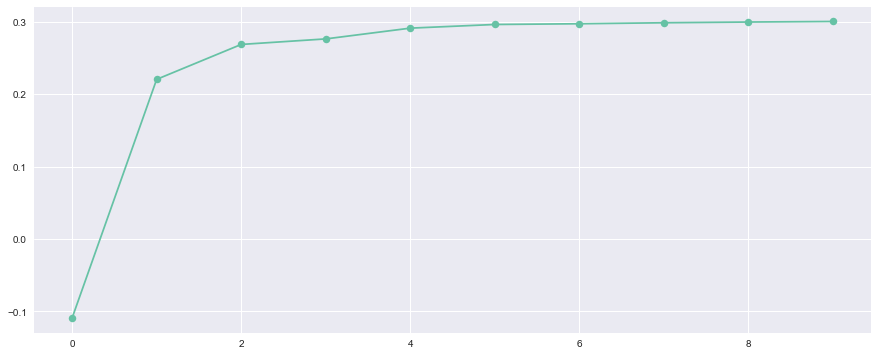

In [100]:
plt.plot(eigenvalues, '.-', markersize=15);

In [101]:
G = nx.from_numpy_matrix(L)
gc = max(nx.connected_component_subgraphs(G), key=len)

In [102]:
assert len(gc.nodes()) == W.shape[0], "GCC should contain all nodes"

# VIZ

In [103]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout, Scattergl

In [104]:
init_notebook_mode(connected=True)
print(__version__)

2.2.2


In [105]:
layout= Layout(
    title= 'TITLE',
    hovermode= 'closest',
    xaxis= dict(
        title= 'EIG 01',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'EIG 02',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)


In [106]:
traces = []

for i in range(eigenvectors.shape[0]):
    scatter_trace = Scattergl(
        x=[eigenvectors[:, 1][i]],
        y=[eigenvectors[:, 2][i]],
        mode='markers',
        name = word_map_used_inv[i],
        marker = dict(
            size = 10,
            color = 'rgba(255, 182, 193, .9)',
            line = dict(
                width = 2,
            )
        )
    )
    traces.append(scatter_trace)

In [107]:

data = traces

fig= Figure(data=data, layout=layout)


In [108]:
iplot(fig)